## MoCo Demo: CIFAR-10

This is a simple demo for training MoCo on CIFAR-10. It can be run directly in a Colab notebook using a publicly available GPU.

#### Results

These are the ResNet-18 classification accuracy of a **kNN monitor** on the unsupervised pre-training features. 

| config | 200ep | 400ep | 800ep |
| --- | --- | --- | --- |
| Asymmetric | 82.6 | 86.3 | 88.7 |
| Symmetric | 85.3 | 88.5 | 89.7 |

#### Notes

* **Symmetric loss**: the original MoCo paper uses an *asymmetric* loss -- one crop is the query and the other crop is the key, and it backpropagates to one crop (query). Following SimCLR/BYOL, here we provide an option of a *symmetric* loss -- it swaps the two crops and computes an extra loss. The symmetric loss behaves like 2x epochs of the asymmetric counterpart: this may dominate the comparison results when the models are trained with a fixed epoch number.

* **SplitBatchNorm**: the original MoCo was trained in 8 GPUs. To simulate the multi-GPU behavior of BatchNorm in this 1-GPU demo, we provide a SplitBatchNorm layer. We set `--bn-splits 8` by default to simulate 8 GPUs. `--bn-splits 1` is analogous to SyncBatchNorm in the multi-GPU case.

* **kNN monitor**: this demo provides a kNN monitor on the test set. Training a linear classifier on frozen features often achieves higher accuracy. To train a linear classifier (not provided in this demo), we recommend using lr=30, wd=0, epochs=100 with a stepwise or cosine schedule. The ResNet-18 model (kNN 89.7) has 90.7 linear classification accuracy.

#### Disclaimer

This demo aims to provide an interface with a free GPU (thanks to Colab) for understanding how the code runs. We suggest users be careful to draw conclusions from CIFAR, which may not generalize beyond this dataset. We have verified that it is beneficial to have the momentum encoder (disabling it by `--moco-m 0.0` should fail), queue size (saturated at `--moco-k 4096`) and ShuffleBN (without which loses 4% at 800 epochs) on CIFAR, similar to the observations on ImageNet. But new observations made only on CIFAR should be judged with caution.

#### References
This demo is adapted from:
* http://github.com/zhirongw/lemniscate.pytorch
* https://github.com/leftthomas/SimCLR








### Prepare

Check GPU settings. A free GPU in Colab is <= Tesla P100. The log of the demo is based on a Tesla V100 from Google Cloud Platform.


In [ ]:
gpu_info = !nvidia-smi -i 0
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

from datetime import datetime

from functools import partial
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet
from tqdm import tqdm
import argparse
import json
import math
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/My Drive')

Mon Dec 28 08:49:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Set arguments

In [ ]:
# set command line arguments here when running in ipynb
batch_size = 256
lr = 0.03
epochs = 200
cos = False
wd = 5e-4

moco_dim = 128
moco_k = 4096
moco_m = 0.99
moco_t = 0.2
bn_splits = 8

knn_k = 200
knn_t = 0.1


schedule = [120, 160, 200, 240] 
symmetric = False
results_dir = './drive/My Drive'
if results_dir == '':
    results_dir = './cache-' + datetime.now().strftime("%Y-%m-%d-%H-%M-%S-moco")


### Define data loaders

In [ ]:
class CIFAR10Pair(CIFAR10):
    """CIFAR10 Dataset.
    """
    def __getitem__(self, index):
        img = self.data[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            im_1 = self.transform(img)
            im_2 = self.transform(img)

        return im_1, im_2
        
import random
from PIL import ImageFilter
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

# data prepare
train_data = CIFAR10Pair(root='data', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

memory_data = CIFAR10(root='data', train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

test_data = CIFAR10(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


### Define base encoder

In [ ]:
# SplitBatchNorm: simulate multi-gpu behavior of BatchNorm in one gpu by splitting alone the batch dimension
# implementation adapted from https://github.com/davidcpage/cifar10-fast/blob/master/torch_backend.py
class SplitBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            running_mean_split = self.running_mean.repeat(self.num_splits)
            running_var_split = self.running_var.repeat(self.num_splits)
            outcome = nn.functional.batch_norm(
                input.view(-1, C * self.num_splits, H, W), running_mean_split, running_var_split, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
            self.running_mean.data.copy_(running_mean_split.view(self.num_splits, C).mean(dim=0))
            self.running_var.data.copy_(running_var_split.view(self.num_splits, C).mean(dim=0))
            return outcome
        else:
            return nn.functional.batch_norm(
                input, self.running_mean, self.running_var, 
                self.weight, self.bias, False, self.momentum, self.eps)

class ModelBase(nn.Module):
    """
    Common CIFAR ResNet recipe.
    Comparing with ImageNet ResNet recipe, it:
    (i) replaces conv1 with kernel=3, str=1
    (ii) removes pool1
    """
    def __init__(self, feature_dim=128, arch=None, bn_splits=16):
        super(ModelBase, self).__init__()

        # use split batchnorm
        norm_layer = partial(SplitBatchNorm, num_splits=bn_splits) if bn_splits > 1 else nn.BatchNorm2d
        # get specified resnet model
        resnet_arch = getattr(resnet, arch)
        net = resnet_arch(num_classes=feature_dim, norm_layer=norm_layer)

        # make changes to original resnet
        self.net = []
        for name, module in net.named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if name == 'fc':
                #print(module.weight.shape[1])
                #module = None
                module = nn.Sequential(nn.Flatten(1), nn.Linear(512, 512),  nn.ReLU(), module)
          
            if isinstance(module, nn.MaxPool2d):
                continue
            
            self.net.append(module)

        # build net
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        x = self.net(x)
        # note: not normalized here
        return x

### Define MoCo wrapper

In [ ]:
class ModelMoCo(nn.Module):
    def __init__(self, dim=128, K=4096, m=0.99, T=0.1, arch='resnet18', bn_splits=8, symmetric=False):
        super(ModelMoCo, self).__init__()

        self.K = K # number of keys
        self.m = m # momentum update param
        self.T = T # temperature hyperparameter to control randomness of preds
        self.symmetric = symmetric

        # create the encoders
        self.encoder_q = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits) # query encoder
        self.encoder_k = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits) # dictionary key encoder

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient, update by EMA of k

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.t()  # transpose
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle_single_gpu(self, x):
        """
        Batch shuffle, for making use of BatchNorm.
        """
        # random shuffle index
        idx_shuffle = torch.randperm(x.shape[0]).cuda()

        # index for restoring
        idx_unshuffle = torch.argsort(idx_shuffle)

        return x[idx_shuffle], idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle_single_gpu(self, x, idx_unshuffle):
        """
        Undo batch shuffle.
        """
        return x[idx_unshuffle]

    def contrastive_loss(self, im_q, im_k):
        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)  # already normalized

        # compute key features
        with torch.no_grad():  # no gradient to keys
            # shuffle for making use of BN
            im_k_, idx_unshuffle = self._batch_shuffle_single_gpu(im_k)

            k = self.encoder_k(im_k_)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)  # already normalized

            # undo shuffle
            k = self._batch_unshuffle_single_gpu(k, idx_unshuffle)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
        
        loss = nn.CrossEntropyLoss().cuda()(logits, labels)

        return loss, q, k

    def forward(self, im1, im2):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            loss
        """

        # update the key encoder
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()

        # compute loss
        if self.symmetric:  # asymmetric loss
            loss_12, q1, k2 = self.contrastive_loss(im1, im2)
            loss_21, q2, k1 = self.contrastive_loss(im2, im1)
            loss = loss_12 + loss_21
            k = torch.cat([k1, k2], dim=0)
        else:  # asymmetric loss
            loss, q, k = self.contrastive_loss(im1, im2)

        self._dequeue_and_enqueue(k)

        return loss

# create model
model = ModelMoCo(
        dim=moco_dim,
        K=moco_k,
        m=moco_m,
        T=moco_t,
        arch = 'resnet18',
        bn_splits=bn_splits,
        symmetric=symmetric,
    ).cuda()
#print(model.encoder_q)

### Define train/test



In [ ]:
# train for one epoch
def train(net, data_loader, train_optimizer, epoch):
    net.train()
    adjust_learning_rate(optimizer, epoch)

    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader, position = 0, leave = True)
    for im_1, im_2 in train_bar:
        im_1, im_2 = im_1.cuda(non_blocking=True), im_2.cuda(non_blocking=True)

        loss = net(im_1, im_2)
        
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += data_loader.batch_size
        total_loss += loss.item() * data_loader.batch_size
        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}'.format(epoch, epochs, optimizer.param_groups[0]['lr'], total_loss / total_num))

    return total_loss / total_num

# lr scheduler for training
def adjust_learning_rate(optimizer, epoch):
    """Decay the learning rate based on schedule"""
    global lr
    global cos
    
    if cos:  # cosine lr schedule
        lr *= 0.5 * (1. + math.cos(math.pi * epoch / epochs))
        if epoch % 25 == 0:
          lr = 0.03
    else:  # stepwise lr schedule
        for milestone in  schedule:
            lr *= 0.1 if epoch == milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# test using a knn monitor
def test(net, memory_data_loader, test_data_loader, epoch):
    global epochs
    net.eval()
    classes = len(memory_data_loader.dataset.classes)
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, target in tqdm(memory_data_loader, desc='Feature extracting', position = 0, leave = True):
            feature = net(data.cuda(non_blocking=True))
            feature = F.normalize(feature, dim=1)
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader, position = 0, leave = True)
        for data, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature = net(data)
            feature = F.normalize(feature, dim=1)
            
            pred_labels = knn_predict(feature, feature_bank, feature_labels, classes,  knn_k, knn_t)

            total_num += data.size(0)
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}%'.format(epoch, epochs, total_top1 / total_num * 100))

    return total_top1 / total_num * 100

# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
    sim_weight = (sim_weight / knn_t).exp()

    # counts for each class
    one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
    # weighted score ---> [B, C]
    pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels

In [ ]:
# define optimizer
lr = 0.03
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)


# load model if resume
resume = './drive/My Drive/moco_v2_best.pth'
epoch_start = 1

if resume is not '':
    checkpoint = torch.load(resume)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start = checkpoint['epoch'] + 1
    print('Loaded from: {}'.format(resume))

Loaded from: ./drive/My Drive/moco_v2_best.pth


### Start training

In [ ]:
# logging

#epoch_start = 1
epochs = 200
lr = 0.003
optimizer.param_groups[0]['lr'] = 0.003
cos = False
# training loop
for epoch in range(epoch_start, epochs + 1):
    train_loss = train(model, train_loader, optimizer, epoch)
    test_acc_1 = test(model.encoder_q, memory_loader, test_loader, epoch)
    # save statistics
    # save model
    torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),},  results_dir + '/moco_v2_last.pth')

In [ ]:
import tensorflow as tf
import numpy as np

(cifar_trainX, cifar_trainY), (cifar_testX, cifar_testY) = tf.keras.datasets.cifar10.load_data()
cifar_trainX = cifar_trainX.astype("float32") / 255.0
cifar_testX = cifar_testX.astype("float32") / 255.0
trainY = tf.keras.utils.to_categorical(cifar_trainY)
testY = tf.keras.utils.to_categorical(cifar_testY)
train_x = np.transpose(cifar_trainX, (0, 3, 1, 2))
train_x = torch.from_numpy(train_x)

#train_x.cuda()

print('done')

170500096/170498071 [==============================] - 2s 0us/step
done


In [ ]:
torch.cuda.empty_cache() 

(2000, 10)


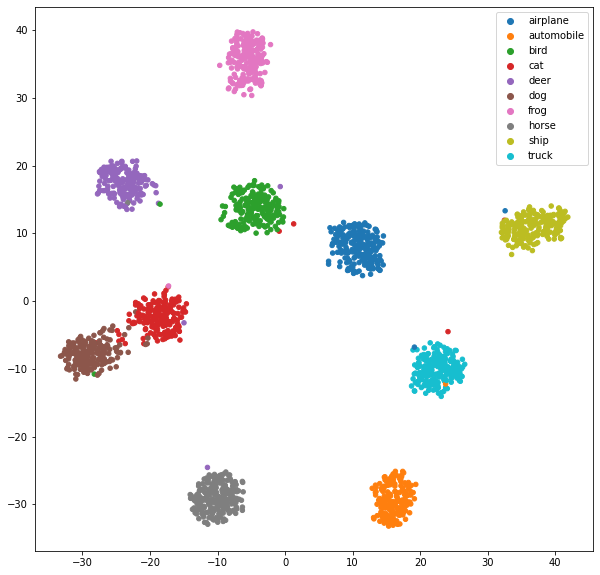

In [ ]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn import manifold

#encoded_test_imgs = resnet(test_x[:1000].cuda()).detach().cpu().numpy()
#generate tsne projection
x = net(train_x[4000:6000].cuda())
x = np.squeeze(x.detach().cpu().numpy())
print(x.shape)
%matplotlib inline

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

#encoded_test_imgs = resnet(test_x[:1000].cuda()).detach().cpu().numpy()
#generate tsne projection

tsne = manifold.TSNE(n_components=2, init='pca', random_state=13, perplexity=70)
X_tsne = tsne.fit_transform(x)

fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1],	c=cifar_trainY[4000:6000], s=20, cmap='tab10')

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.show() 

Linear Eval


In [ ]:

for epoch in range(800):
  lr *= 0.5 * (1. + math.cos(math.pi * epoch / ))
  if epoch % 100 == 0:
    lr = 0.03
  print(lr)
  
  

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision

for param in model.encoder_q.parameters():
  param.requires_grad = False

new_model = nn.Sequential(*list(model.encoder_q.children())[0][:-1])



lr = 0.03
for param in new_model.parameters():
  param.requires_grad = False

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
    #self.encoder = new_model
    self.fc = nn.Linear(512, 10)

  def forward(self, x):
    out = new_model(x)
    out = nn.Flatten(1)(out)
    out = self.fc(out)

    return out
        
net = Net()
net.cuda()
lr = 3
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay = 1e-5, momentum=0.9)

train_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

data_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
data_loader = torch.utils.data.DataLoader(data_set, batch_size=128,
                                          shuffle=True, num_workers=16, pin_memory = True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128,
                                          shuffle=False, num_workers=16, pin_memory = True)



def train_val(net, data_loader, train_optimizer):
    global lr
    schedule = [20, 40]
    criterion = nn.CrossEntropyLoss().cuda()
    is_train = train_optimizer is not None
    net.train() if is_train else net.eval()

    total_loss, total_correct_1, total_correct_3, total_num, data_bar = 0.0, 0.0, 0.0, 0, tqdm(data_loader, position=0, leave=True)
    with (torch.enable_grad() if is_train else torch.no_grad()):
      
        for data, target in data_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            out = net(data)
            loss = criterion(out, target)
            if is_train:
              train_optimizer.zero_grad()
              loss.backward()
              train_optimizer.step()

            total_num += data.size(0)
            total_loss += loss.item() * data.size(0)
            prediction = torch.argsort(out, dim=-1, descending=True)
            total_correct_1 += torch.sum((prediction[:, 0:1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_correct_3 += torch.sum((prediction[:, 0:3] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()

            data_bar.set_description('{} Epoch: [{}/{}] lr: {:.4f} Loss: {:.4f} ACC@1: {:.2f}% ACC@5: {:.2f}%'
                                     .format('Train' if is_train else 'Test', epoch, epochs, lr, total_loss / total_num,
                                             total_correct_1 / total_num * 100, total_correct_3 / total_num * 100))
            
      
    if is_train:
      if schedule is not None:
        for milestone in schedule:
            lr *= 0.1 if epoch == milestone else 1.
        for param_group in train_optimizer.param_groups:
            param_group['lr'] = lr



Files already downloaded and verified
Files already downloaded and verified


# Linear Evaluation

190 epoch, asymmetric, scheduled loss (120, 160), adam optimizer (lr 1e-3, wd 1e-6)

train, test: top 1 acc: 74.5%, top 3 acc: 93.9%

using fc from original net: top 1: 79.5% top 3: 95.8

using block 4: 72% top 1, 92% top 3

using block 3: 59% top 1, 85% top 3

using block 2: 36% top 1, 63% TOP 3

In [ ]:
for param in net.parameters():
  print(param.requires_grad)

In [ ]:
epochs = 100
for epoch in range(1, epochs+1):
  train_val(net, data_loader, optimizer)
  train_val(net, test_loader, None)
  


Train Epoch: [1/100] lr: 3.0000 Loss: 0.6377 ACC@1: 79.67% ACC@5: 94.98%: 100%|██████████| 391/391 [00:14<00:00, 27.66it/s]
Test Epoch: [1/100] lr: 3.0000 Loss: 0.5360 ACC@1: 81.63% ACC@5: 96.45%: 100%|██████████| 79/79 [00:03<00:00, 21.21it/s]
Train Epoch: [2/100] lr: 3.0000 Loss: 0.4931 ACC@1: 82.93% ACC@5: 96.71%: 100%|██████████| 391/391 [00:14<00:00, 27.29it/s]
Test Epoch: [2/100] lr: 3.0000 Loss: 0.5087 ACC@1: 82.36% ACC@5: 96.60%: 100%|██████████| 79/79 [00:03<00:00, 20.96it/s]
Train Epoch: [3/100] lr: 3.0000 Loss: 0.4747 ACC@1: 83.62% ACC@5: 96.88%: 100%|██████████| 391/391 [00:14<00:00, 27.39it/s]
Test Epoch: [3/100] lr: 3.0000 Loss: 0.5014 ACC@1: 82.63% ACC@5: 96.73%: 100%|██████████| 79/79 [00:03<00:00, 20.86it/s]
Train Epoch: [4/100] lr: 3.0000 Loss: 0.4705 ACC@1: 83.57% ACC@5: 96.97%: 100%|██████████| 391/391 [00:14<00:00, 27.37it/s]
Test Epoch: [4/100] lr: 3.0000 Loss: 0.5149 ACC@1: 82.19% ACC@5: 96.66%: 100%|██████████| 79/79 [00:03<00:00, 20.88it/s]
Train Epoch: [5/100]

# 4000 label benchmark

In [ ]:
resume = './drive/My Drive/moco_v2_best.pth'
epoch_start = 1
if resume is not '':
    checkpoint = torch.load(resume)
    model.load_state_dict(checkpoint['state_dict'])
    
    #optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start = checkpoint['epoch'] + 1
    print('Loaded from: {}'.format(resume))

Loaded from: ./drive/My Drive/moco_v2_best.pth


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision
import numpy as np


new_model = nn.Sequential(*list(model.encoder_q.children())[0][:-1])

for param in new_model:
  param.requires_grad = False

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc = nn.Linear(512, 10)
  def forward(self, x):
    out = new_model(x)
    out = nn.Flatten(1)(out)
    out = self.fc(out)

    return out
        
net = Net()
net.cuda()

lr = 3e-3
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = 1e-5)

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=False, num_workers=4, pin_memory = True)

def get_indices(dataset, num_classes):
  indices = []
  for Class in range(10):
    for j in range(num_classes):
      x = np.random.randint(0, 50000)
      while dataset.targets[x] != Class:
        x = np.random.randint(0, 50000)
      indices.append(x)
  return indices


def train_val(net, data_loader, train_optimizer):
    global lr
    schedule = [20, 40]
    criterion = nn.CrossEntropyLoss().cuda()
    is_train = train_optimizer is not None
    net.train() if is_train else net.eval()

    total_loss, total_correct_1, total_correct_3, total_num, data_bar = 0.0, 0.0, 0.0, 0, tqdm(data_loader, position=0, leave=True)
    with (torch.enable_grad() if is_train else torch.no_grad()):
        for data, target in data_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            out = net(data)
            loss = criterion(out, target)

            if is_train:
                train_optimizer.zero_grad()
                loss.backward()
                train_optimizer.step()


            total_num += data.size(0)
            total_loss += loss.item() * data.size(0)
            prediction = torch.argsort(out, dim=-1, descending=True)
            total_correct_1 += torch.sum((prediction[:, 0:1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_correct_3 += torch.sum((prediction[:, 0:3] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()

            data_bar.set_description('{} Epoch: [{}/{}] lr: {:.4f} Loss: {:.4f} ACC@1: {:.2f}% ACC@5: {:.2f}%'
                                     .format('Train' if is_train else 'Test', epoch, epochs, lr, total_loss / total_num,
                                             total_correct_1 / total_num * 100, total_correct_3 / total_num * 100))
            
    if is_train:
      if schedule is not None:
        for milestone in schedule:
            lr *= 0.1 if epoch == milestone else 1.
        for param_group in train_optimizer.param_groups:
            param_group['lr'] = lr

    return total_correct_1 / total_num * 100



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import numpy as np

train_acc = []
test_acc = []
for i in range(5):
  print(f"Random Seed: {i}")
  best_train = 0
  best_test = 0
  np.random.seed(i)

  indices = get_indices(dataset, 1000)
  sampler = torch.utils.data.SubsetRandomSampler(indices)

  train_loader = DataLoader(dataset, batch_size=64, sampler = sampler , num_workers=16, pin_memory=True)

  new_model = nn.Sequential(*list(model.encoder_q.children())[0][:-1])

  for param in new_model.parameters():
    param.requires_grad = True

  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
      self.encoder = new_model
      self.fc = nn.Linear(512, 10)

    def forward(self, x):
      out = self.encoder(x)
      out = nn.Flatten(1)(out)
      out = self.fc(out)

      return out
          
  net = Net()
  net.cuda()

  lr = 3e-4
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = 1e-5)

  epoch_start = 1
  epochs = 50
  for epoch in range(epoch_start, epochs+1):
    acc1 = train_val(net, train_loader, optimizer)
    acc2 = train_val(net, test_loader, None)
    if acc1 > best_train:
      best_train = acc1
    if acc2 > best_test:
      best_test = acc2
  train_acc.append(acc1)
  test_acc.append(acc2)

print(train_acc)
print(test_acc)

train_acc = np.array(train_acc)
test_acc = np.array(test_acc)
print(np.mean(train_acc))
print(np.mean(test_acc))
print(np.std(train_acc))
print(np.std(test_acc))


Random Seed: 0


Train Epoch: [1/50] lr: 0.0003 Loss: 1.8260 ACC@1: 46.21% ACC@5: 72.10%:   4%|▍         | 7/157 [00:02<00:48,  3.07it/s]

KeyboardInterrupt: ignored

In [ ]:
train_acc = []
test_acc = []
for i in range(5):
  print(f"Random Seed: {i}")
  best_train = 0
  best_test = 0
  np.random.seed(i)

  indices = get_indices(train_data, 400)
  sampler = torch.utils.data.SubsetRandomSampler(indices)

  train_loader = DataLoader(train_data, batch_size=batch_size, sampler = sampler , num_workers=16, pin_memory=True)

  resnet18 = ModelBase()
  resnet18.cuda()
  lr = 1e-3
  optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr, weight_decay = 1e-5)
  epoch_start = 1
  epochs = 100
  for epoch in range(epoch_start, epochs+1):
    acc1 = train_val(resnet18, train_loader, optimizer)
    acc2 = train_val(resnet18, test_loader, None)
    if acc1 > best_train:
      best_train = acc1
    if acc2 > best_test:
      best_test = acc2
  train_acc.append(acc1)
  test_acc.append(acc2)

print(train_acc)
print(test_acc)
import numpy as np
train_acc = np.array(train_acc)
test_acc = np.array(test_acc)
print(np.mean(train_acc))
print(np.mean(test_acc))
print(np.std(train_acc))
print(np.std(test_acc))


In [ ]:
import os
import sys
import h5py
import cv2
import math
import random, string

import numpy as np
from scipy.stats import norm
from sklearn import manifold
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from google.colab.patches import cv2_imshow

#from model import getModels
#from config import latent_dim, imageSize, visualsPath
#from datasetTools import loadDataset
latent_dim = 128
imageSize = 32
# Show every image, good for picking interplation candidates
def visualizeDataset(X):
    for i,image in enumerate(X):
        cv2_imshow(image)
        cv2.waitKey()
        cv2.destroyAllWindows()

# Scatter with images instead of points
def imscatter(x, y, ax, imageData, zoom):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]
        # Convert to image
        img = imageData[i]*255.
        img = img.astype(np.uint8).reshape([imageSize,imageSize,3])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        # Note: OpenCV uses BGR and plt uses RGB
        image = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

# Show dataset images with T-sne projection of latent space encoding
def computeTSNEProjectionOfLatentSpace(X, Y, display=True):
    # Compute latent space representation
    print("Computing latent space projection...")
    #X_encoded = resnet(train_x[:1000].cuda()).detach().cpu().numpy()
    x = model.encoder_q(train_x[:1000].cuda())
    x = np.squeeze(x.detach().cpu().numpy())
    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0,perplexity=50)
    X_tsne = tsne.fit_transform(x)

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(40,40))
        print(ax)
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=Y, ax=ax, zoom=1.1)
        plt.savefig('Tsne_LatentSpace_Projection.jpg')
        plt.show()
        
    else:
        return X_tsne

# Show dataset images with T-sne projection of pixel space
def computeTSNEProjectionOfPixelSpace(X, display=True):
    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0,perplexity=50)
    X_tsne = tsne.fit_transform(X.reshape([-1,imageSize*imageSize*3]))

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(30,30))
        fg=imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=1.1)
        plt.savefig('Tsne_PixelSpace_Projection.jpg')
        plt.show()
        
    else:
        return X_tsne



Computing latent space projection...
Computing t-SNE embedding...
Plotting t-SNE visualization...
AxesSubplot(0.125,0.125;0.775x0.755)


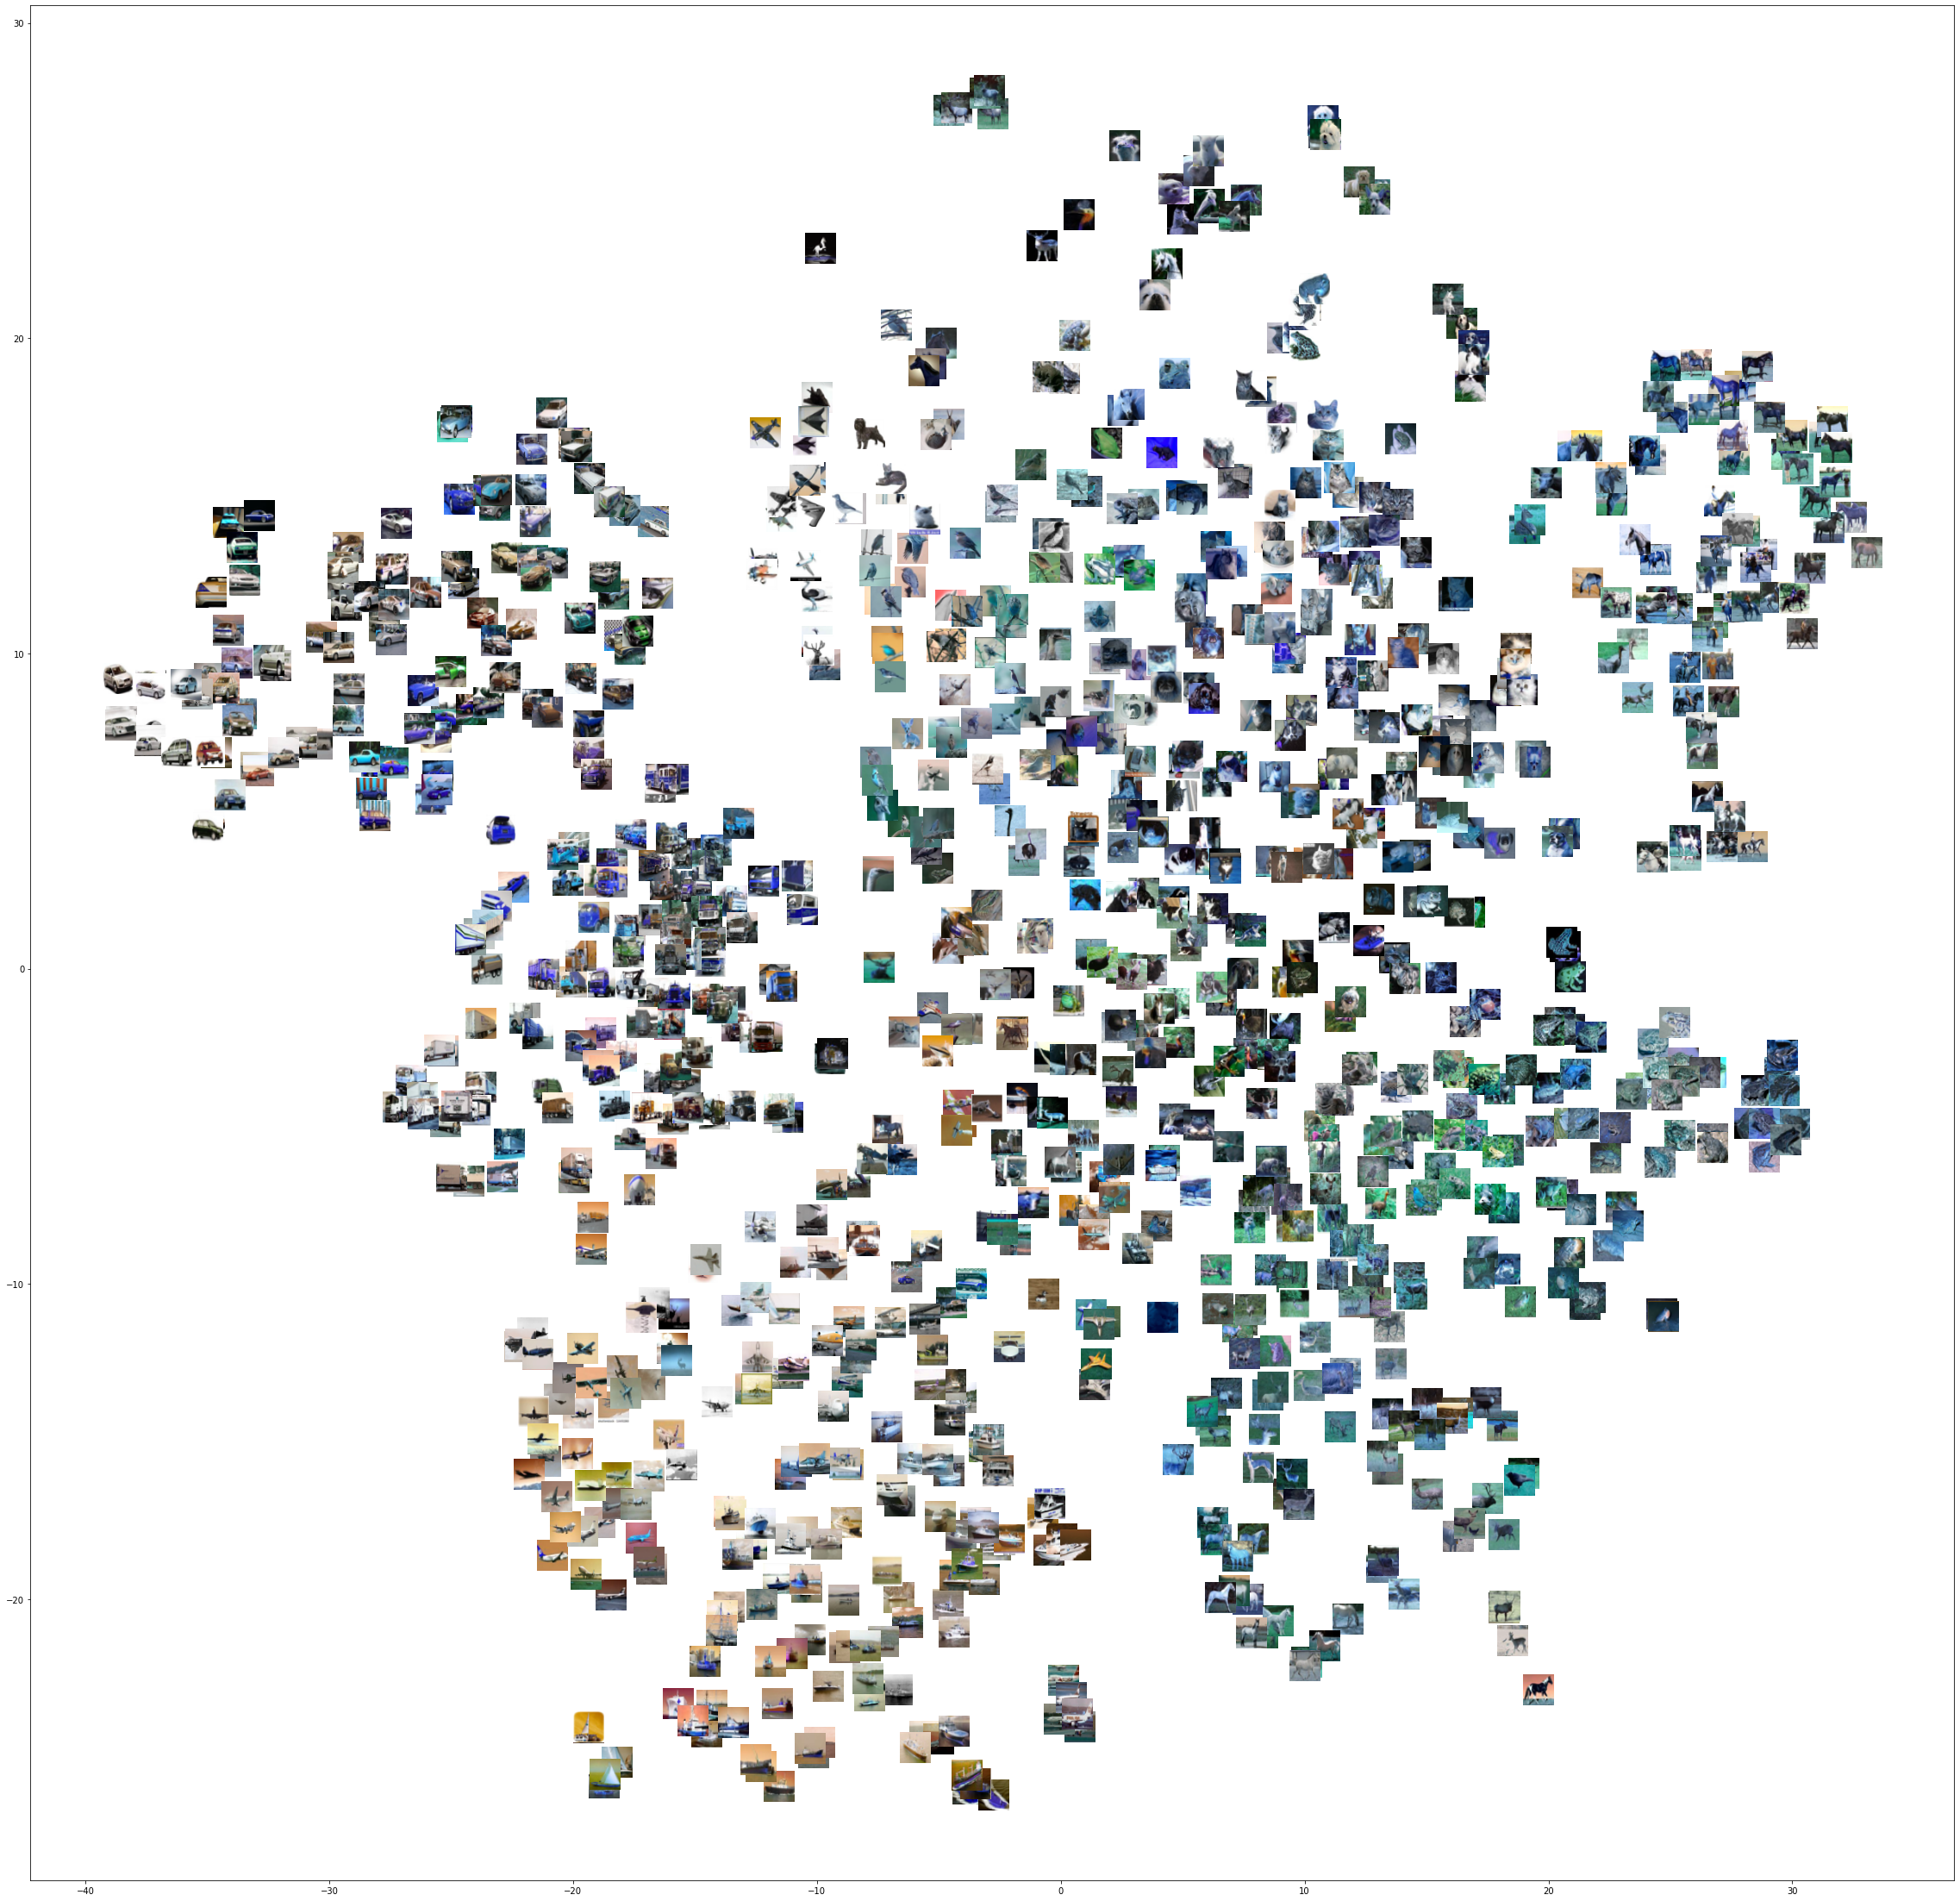

In [ ]:
computeTSNEProjectionOfLatentSpace(train_x[:1000], cifar_trainX[:1000], display=True)